In [81]:
# Importing necessary libraries

import numpy as np
import os
import re
import sys
import glob
from textwrap import wrap
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Concatenate, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [76]:
# Setting up the paths for images and captions dataset

img_path = '/home/devcontainers/Deep_Learning/RNN/image_caption/Flicker8k_Dataset'
caption_path = '/home/devcontainers/Deep_Learning/RNN/image_caption/Flickr8k.token.txt'
caption = pd.read_csv(caption_path, sep='\t', header=None, names=['image', 'caption'])

def clean_imagefile(filename):
    filename = filename.split('#')[0]
    match = re.match(r'(.*\.jpg)', filename)
    if match:
        return match.group(1)
    if not filename.endswith('.jpg'):
        filename += '.jpg'
    return filename
    
caption['image_clean'] = caption['image'].apply(clean_imagefile)
caption.head()

,image,caption,image_clean
0,1000268201_693b08cb0e.jpg#0,A child in a pink dress is climbing up a set o...,1000268201_693b08cb0e.jpg
1,1000268201_693b08cb0e.jpg#1,A girl going into a wooden building .,1000268201_693b08cb0e.jpg
2,1000268201_693b08cb0e.jpg#2,A little girl climbing into a wooden playhouse .,1000268201_693b08cb0e.jpg
3,1000268201_693b08cb0e.jpg#3,A little girl climbing the stairs to her playh...,1000268201_693b08cb0e.jpg
4,1000268201_693b08cb0e.jpg#4,A little girl in a pink dress going into a woo...,1000268201_693b08cb0e.jpg


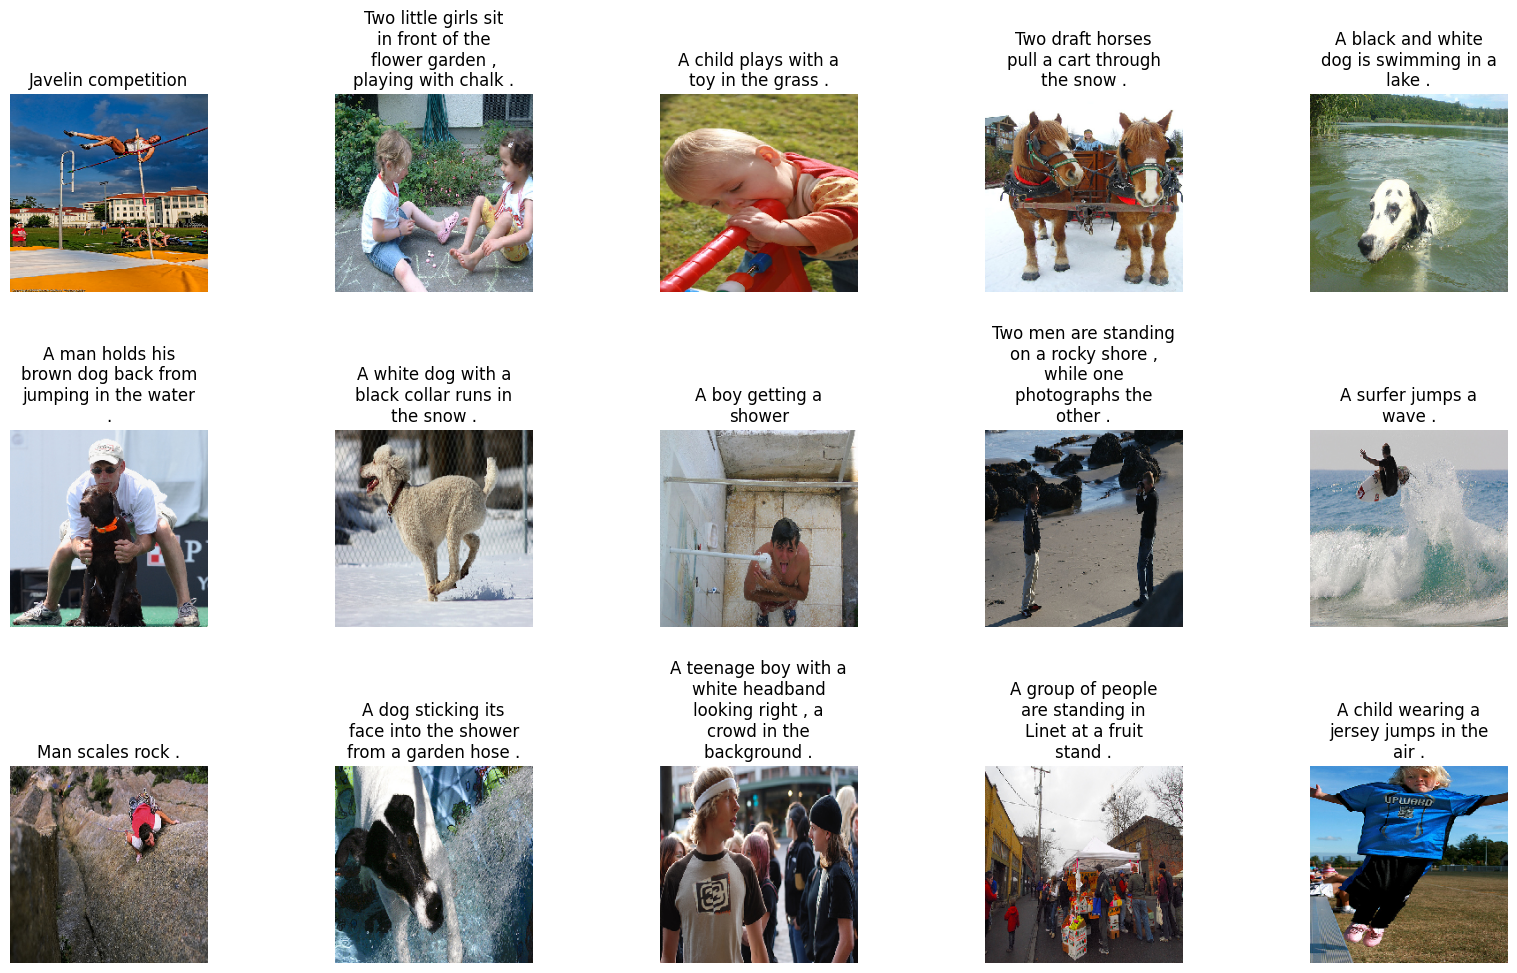

In [77]:
# Functions to read, preprocess and display images

def read_image(image_path):
    img = load_img(image_path, color_mode='rgb', target_size=(224, 224))
    img = img_to_array(img)
    # img = np.expand_dims(img, axis=0)
    # img = preprocess_input(img)
    img /= 255.0
    return img

def display_image(image_df):
    image_df = image_df.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    i=0
    for i in range(len(image_df)):
        plt.subplot(5,5,i+1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        img = read_image(os.path.join(img_path, image_df.image_clean[i]))
        plt.imshow(img)
        plt.title("\n".join(wrap(image_df.caption[i], 20)))
        plt.axis('off')

display_image(caption.sample(15))

In [78]:
# Function to preprocess texts to reduce redundancy with start and end tokens
def preprocess_texts(caption_df):
    caption_df['caption'] = caption_df['caption'].apply(lambda x: x.lower())
    caption_df['caption'] = caption_df['caption'].apply(lambda x: re.sub("[^A-Za-z]"," ",x))
    caption_df['caption'] = caption_df['caption'].apply(lambda x: re.sub("\s+", " ",x))
    caption_df['caption'] = caption_df['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    caption_df['caption'] = caption_df['caption'].apply(lambda x: f"startseq {x} endseq")
    
    return caption_df

caption = preprocess_texts(caption)
captions = caption['caption'].tolist()
caption.head()

,image,caption,image_clean
0,1000268201_693b08cb0e.jpg#0,startseq child in pink dress is climbing up se...,1000268201_693b08cb0e.jpg
1,1000268201_693b08cb0e.jpg#1,startseq girl going into wooden building endseq,1000268201_693b08cb0e.jpg
2,1000268201_693b08cb0e.jpg#2,startseq little girl climbing into wooden play...,1000268201_693b08cb0e.jpg
3,1000268201_693b08cb0e.jpg#3,startseq little girl climbing the stairs to he...,1000268201_693b08cb0e.jpg
4,1000268201_693b08cb0e.jpg#4,startseq little girl in pink dress going into ...,1000268201_693b08cb0e.jpg


In [79]:
# Tokenizing the captions to create list of indices
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = 1+len(tokenizer.word_index)
maxLen = max([len(c.split()) for c in captions])
print(f"Vocabulary Size: {vocab_size}, Max Length of Caption: {maxLen}")

images = caption['image_clean'].unique().tolist()
num_images = len(images)
print(f"Number of unique Images: {num_images}")

split_idx = round(num_images * 0.8)
train_images = images[:split_idx]
test_images = images[split_idx:]
print(f"Number of Training Images: {len(train_images)}, Number of Testing Images: {len(test_images)}")

train = caption[caption['image_clean'].isin(train_images)].reset_index(inplace=True, drop=True)
test = caption[caption['image_clean'].isin(test_images)].reset_index(inplace=True, drop=True)

Vocabulary Size: 8427, Max Length of Caption: 35
Number of unique Images: 8091
Number of Training Images: 6473, Number of Testing Images: 1618


In [80]:
# Getting the features or encodings for a given image using DenseNet201

img_model = DenseNet201()
model = Model(inputs=img_model.input, outputs=img_model.layers[-2].output)
features = {}
for image in caption['image_clean'].unique().tolist():
    img_file = os.path.join(img_path, image)
    if not os.path.exists(img_file):
        print(f"Missing: {img_file}")
        continue
    img = load_img(img_file, target_size=(224, 224))
    img = img_to_array(img)
    img /= 255.0
    img = np.expand_dims(img, axis=0)
    feature = model.predict(img)
    features[image] = feature

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━

In [83]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, caption_df, X_col, y_col, batch_size, directory, tokenizer, vocab_size, maxLen, features, shuffle=True):
        self.caption_df = caption_df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.directory = directory
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.maxLen = maxLen
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.caption_df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.caption_df = self.caption_df.sample(frac=1).reset_index(drop=True)
            
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, index):
        batch_df = self.caption_df.iloc[index*self.batch_size:(index+1)*self.batch_size,:]
        X1, X2, y = self.__get_data(batch_df)
        return (X1, X2), y
    
    def __get_data(self, batch_df):
        X1, X2, y = [], [], []
        images = batch_df[self.X_col].tolist()
        for image in images:
            feature = self.features[image][0]
            captions = batch_df[batch_df[self.X_col] == image][self.y_col].tolist()
            for c in captions:
                seq = self.tokenizer.texts_to_sequences([c])[0]
                for i in range(1, len(seq)):
                    in_seq = seq[:i]
                    out_seq = seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.maxLen)[0]
                    out_seq = to_categorical(out_seq, num_classes=self.vocab_size)
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        
        return X1, X2, y